[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_CAMS.png)](https://atmosphere.copernicus.eu)

# CAMS Global Atmospheric Composition Forecast Practical

**Run the tutorial via free cloud platforms**: [![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/cams-act6/03-model/main?labpath=cams-global-forecast.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/cams-act6/03-model/blob/main/cams-global-forecast.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/cams-act6/03-model/blob/main/cams-global-forecast.ipynb)


## Initial setup

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the Climate Data Store (CDS), intalling any other packages not already installed, setting up our CDS API credentials and importing the various Python libraries that we will need.

In [1]:
# Ensure that the cdsapi package is installed
!pip install -q cdsapi

In [2]:
# If you are running this notebook in Colab, uncomment the line below and run this cell.
# !pip install cartopy

### Add your CDS API credentials (optional)

To set up your CDS API credentials, please follow the [instructions here](https://cds-beta.climate.copernicus.eu/how-to-api). 

Alternatively, you can add them to your current session by uncommenting and executing the code in the following cell:

In [3]:
# import os
# os.environ['CDSAPI_URL'] = 'https://ads.atmosphere.copernicus.eu/api/v2'
# os.environ['CDSAPI_KEY'] = '###########################################'

### Import libraries

In [4]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [5]:
DATADIR = './cams-global-forecast-data'

## Explore and download data

Visit the download form for the CAMS global forecast data https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=form. View the parameters in the API script in the following cell and select the corresponding options. 

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (the cell below).

**Please remember to accept the terms and conditions at the bottom of the download form.**


### Download data

With the API request copied into the cell below, running this cell will retrieve and download the data you requested into your local directory.

In [6]:
c = cdsapi.Client()

c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'variable': 'total_aerosol_optical_depth_550nm',
        'date': '2024-06-26/2024-06-26',
        'time': '00:00',
        'leadtime_hour': [
            '0', '108', '12',
            '120', '24', '36',
            '48', '60', '72',
            '84', '96',
        ],
        'type': 'forecast',
        'format': 'netcdf', # can change "netcdf_zip" to "netcdf" to download NetCDF (not Zip) file
    },
    f'{DATADIR}/total-aod-550nm-global-5day-forecast.nc')

2024-09-02 12:39:45,451 INFO Welcome to the CDS
2024-09-02 12:39:45,458 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2024-09-02 12:39:45,642 INFO Request is completed
2024-09-02 12:39:45,644 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data7/adaptor.mars_constrained.external-1725272905.499477-22219-3-c2bcfb1a-c2e7-4a4f-874f-77bac6db154f.nc to ./cams-global-forecast-data/total-aod-550nm-global-5day-forecast.nc (8.5M)
2024-09-02 12:39:47,871 INFO Download rate 3.8M/s                                                                      


Result(content_length=8936364,content_type=application/x-netcdf,location=https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data7/adaptor.mars_constrained.external-1725272905.499477-22219-3-c2bcfb1a-c2e7-4a4f-874f-77bac6db154f.nc)

## Inspect data

In [7]:
# Path to the downloaded file
netcdf_file = f'{DATADIR}/total-aod-550nm-global-5day-forecast.nc'

# Create Xarray Dataset
ds = xr.open_dataset(netcdf_file)

# view the dataset
ds

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 451, time: 11)
Coordinates:
  * longitude  (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-06-26 ... 2024-07-01
Data variables:
    aod550     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-09-02 10:28:25 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [9]:
# create xarray data array object (single variable)
da = ds['aod550']
da

<xarray.DataArray 'aod550' (time: 11, latitude: 451, longitude: 900)>
[4464900 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2024-06-26 ... 2024-07-01
Attributes:
    units:      ~
    long_name:  Total Aerosol Optical Depth at 550nm

## Plot global map of forecast

### Define time step

time_step = 0

In [17]:
lead_times = da['time']
forecast_day = str(lead_times[time_step].to_numpy())[:10]
forecast_day

'2024-06-26'

### Plot map for given time step

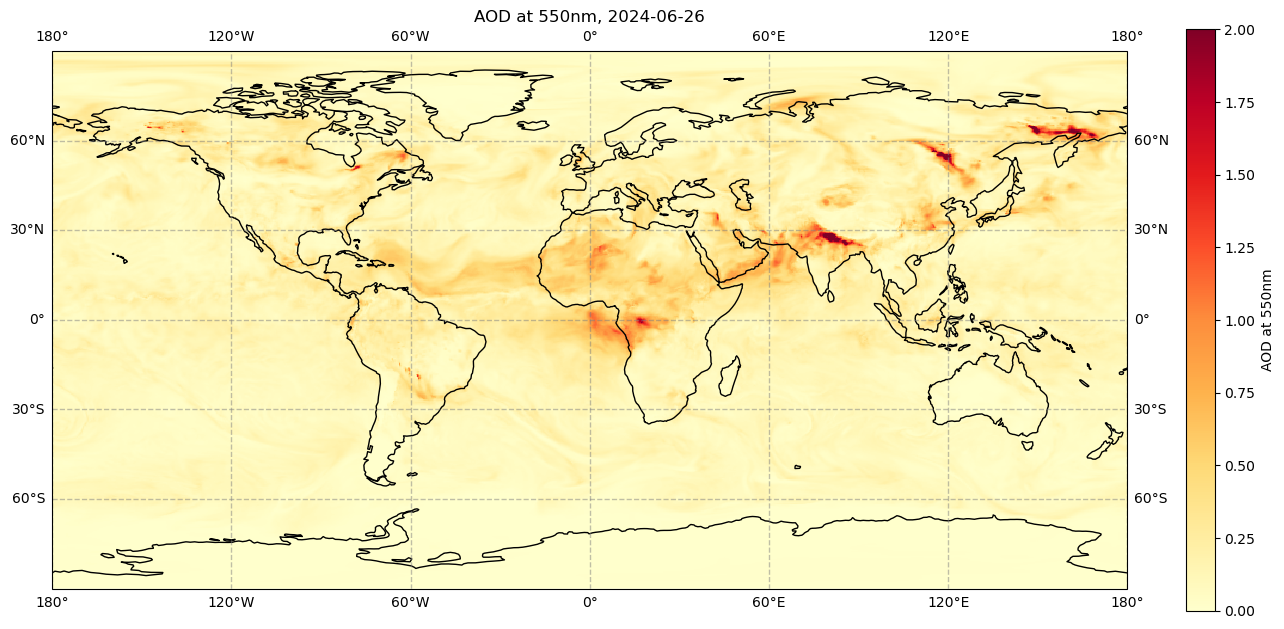

In [18]:
# create the figure panel and specify size
fig = plt.figure(figsize=(15, 10))

# create the map using the cartopy PlateCarree projection
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Add lat/lon grid
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Set figure title
ax.set_title(f'AOD at 550nm, {forecast_day}', fontsize=12) 

# Plot the data
im = plt.pcolormesh(da.longitude, da.latitude, da[time_step,:,:], cmap='YlOrRd', vmin=0, vmax=2) 

# Add coastlines
ax.coastlines(color='black') 

# Specify the colourbar, including fraction of original axes to use for colorbar, 
# and fraction of original axes between colorbar and new image axes
cbar = plt.colorbar(im, fraction=0.025, pad=0.05) 

# Define the colourbar label
cbar.set_label('AOD at 550nm') 

# Save the figure
#fig.savefig(f'{DATADIR}/total-aod-550nm-global-5day-forecast.png')

## Plot time series for given latitude and longitude

### Select location

In [19]:
oslo_lat = 59.9124 
oslo_lon = 10.733716997341721

In [21]:
oslo_da = da.sel(latitude = oslo_lat, longitude = oslo_lon, method='nearest')
oslo_da

<xarray.DataArray 'aod550' (time: 11)>
[11 values with dtype=float32]
Coordinates:
    longitude  float32 10.8
    latitude   float32 60.0
  * time       (time) datetime64[ns] 2024-06-26 ... 2024-07-01
Attributes:
    units:      ~
    long_name:  Total Aerosol Optical Depth at 550nm

### Plot time series

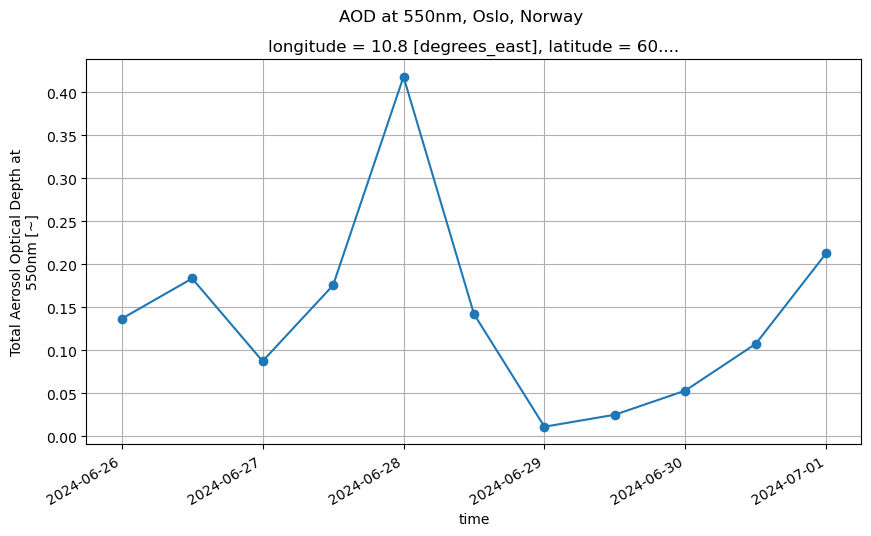

In [23]:
fig = plt.figure(figsize=(10, 5))
oslo_da.plot(marker='o')
plt.suptitle("AOD at 550nm, Oslo, Norway")
plt.grid(True)